Library

In [1]:
!pip install Sastrawi imbalanced-learn wordcloud

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import random
import time

import nltk
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,precision_recall_fscore_support
from collections import Counter
from wordcloud import WordCloud

sns.set(style="whitegrid")
pd.set_option('display.max_colwidth', 100)
print(" Semua Library Berhasil Di-load!")

 Semua Library Berhasil Di-load!


**load data**

Total Data Awal: 269652


/tmp/ipython-input-1298153804.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='category', palette='viridis')


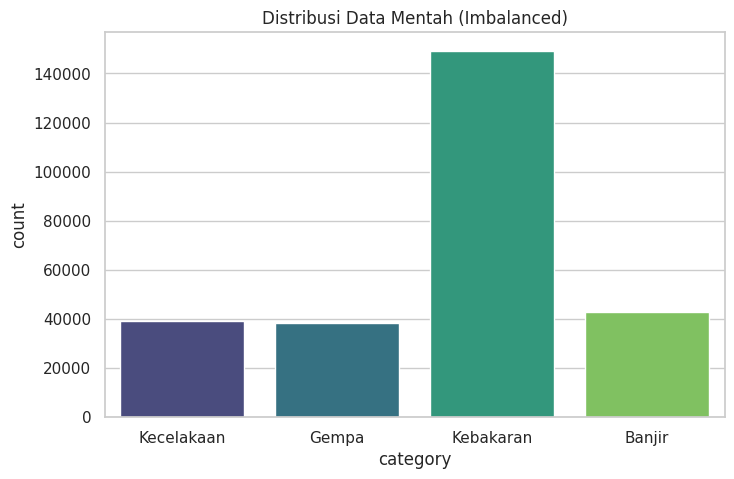

Duplikat awal: 13069
Total Data Bersih (No Duplikat): 256582


In [3]:
# 1. Load Data
try:
    path = 'disaster_response_classification/data/raw_data/'
    df_accident = pd.read_csv(path + 'accident.csv')
    df_earthquake = pd.read_csv(path + 'earthquake.csv')
    df_fire = pd.read_csv(path + 'fire.csv')
    df_flood = pd.read_csv(path + 'flood.csv')

    df_accident['category'] = 'Kecelakaan'
    df_earthquake['category'] = 'Gempa'
    df_fire['category'] = 'Kebakaran'
    df_flood['category'] = 'Banjir'

    df = pd.concat([df_accident, df_earthquake, df_fire, df_flood], ignore_index=True)
    print(f"Total Data Awal: {len(df)}")

except FileNotFoundError:
    print("Error: File tidak ditemukan. Cek path folder Anda.")

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='category', palette='viridis')
plt.title('Distribusi Data Mentah (Imbalanced)')
plt.show()

print(f"Duplikat awal: {df.duplicated(subset='full_text').sum()}")
df.dropna(subset=['full_text'], inplace=True)
df.drop_duplicates(subset=['full_text'], keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)

print(f"Total Data Bersih (No Duplikat): {len(df)}")

**PREPROCESSING**

In [4]:
factory = StopWordRemoverFactory()
stopword_list = factory.get_stop_words()
tambahan_stopword = ['yg', 'dg', 'rt', 'dgn', 'ny', 'd', 'klo', 'kalo', 'amp', 'biar',
                     'bikin', 'bilang', 'gak', 'ga', 'krn', 'nya', 'nih', 'sih',
                     'si', 'tau', 'tdk', 'tuh', 'utk', 'ya', 'jd', 'jgn', 'sdh', 'aja']
stopword_set = set(stopword_list + tambahan_stopword)

def clean_text_v2(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stopword_set]
    return " ".join(filtered_words)

print("Sedang membersihkan teks")
df['text_clean'] = df['full_text'].apply(clean_text_v2)
df['text_final'] = df['text_clean'].apply(remove_stopwords)

le = LabelEncoder()
df['label'] = le.fit_transform(df['category'])
label_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print("Mapping Label:", label_mapping)
display(df[['full_text', 'text_final']].head(3))

Sedang membersihkan teks
Mapping Label: {np.int64(0): 'Banjir', np.int64(1): 'Gempa', np.int64(2): 'Kebakaran', np.int64(3): 'Kecelakaan'}


,full_text,text_final
0,https://t.co/18q5w1w4Qa : Angka Kecelakaan Selama Operasi Lilin 2017 Diklaim Menurun: Jakarta: ...,angka kecelakaan selama operasi lilin diklaim menurun jakarta terjadi
1,"Kecelakaan kerja bukanlah kebetulan, dia merupakan sebuah akibat. #TerapiYumeiho",kecelakaan kerja bukanlah kebetulan merupakan sebuah akibat terapiyumeiho
2,Bos Raksasa Katering Inggris Tewas dalam Kecelakaan Pesawat https://t.co/adMzirqD1h https://t.co...,bos raksasa katering inggris tewas kecelakaan pesawat


**Data Splitting**

In [5]:
X = df['text_final']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Data Training: {len(X_train)}")
print(f"Data Testing : {len(X_test)}")

Data Training: 205265
Data Testing : 51317


In [6]:
print(" Memulai Operasi Smart Augmentation...")

kamus_pintar = {
    0: ["air meluap", "tenggelam", "tergenang air", "sungai meluap", "air bah", "banjir bandang", "tanggul jebol"],
    1: ["tanah berguncang", "lindu", "getaran tanah", "bumi bergoyang", "guncangan hebat", "tembok retak"],
    2: ["si jago merah", "dilalap api", "hangus terbakar", "kobaran api", "asap mengepul", "memadamkan api"],
    3: ["tabrakan beruntun", "adu banteng", "rem blong", "kendaraan ringsek", "terguling", "kecelakaan maut"]
}

tambahan_text = []
tambahan_label = []

for label, frasa_list in kamus_pintar.items():
    for _ in range(200):
        frasa = random.choice(frasa_list)
        template = [f"Tolong ada {frasa}", f"Info {frasa} parah", f"Waspada {frasa}", f"Akibat {frasa} warga panik"]
        tambahan_text.append(random.choice(template))
        tambahan_label.append(label)

df_aug = pd.DataFrame({'text': tambahan_text, 'label': tambahan_label})
df_aug['text_clean'] = df_aug['text'].apply(clean_text_v2)

rus = RandomUnderSampler(random_state=42)

df_train_temp = pd.DataFrame({'text': X_train, 'label': y_train})
X_res, y_res = rus.fit_resample(df_train_temp[['text']], df_train_temp['label'])
df_balanced = pd.DataFrame({'text': X_res['text'], 'label': y_res})

df_aug_boosted = pd.concat([df_aug] * 30, ignore_index=True)

X_train_final = pd.concat([df_balanced['text'], df_aug_boosted['text_clean']], ignore_index=True)
y_train_final = pd.concat([df_balanced['label'], df_aug_boosted['label']], ignore_index=True)

print(f"Total Training Akhir (Balanced + Boosted): {len(X_train_final)}")

 Memulai Operasi Smart Augmentation...
Total Training Akhir (Balanced + Boosted): 128796


**EDA World CLoud**

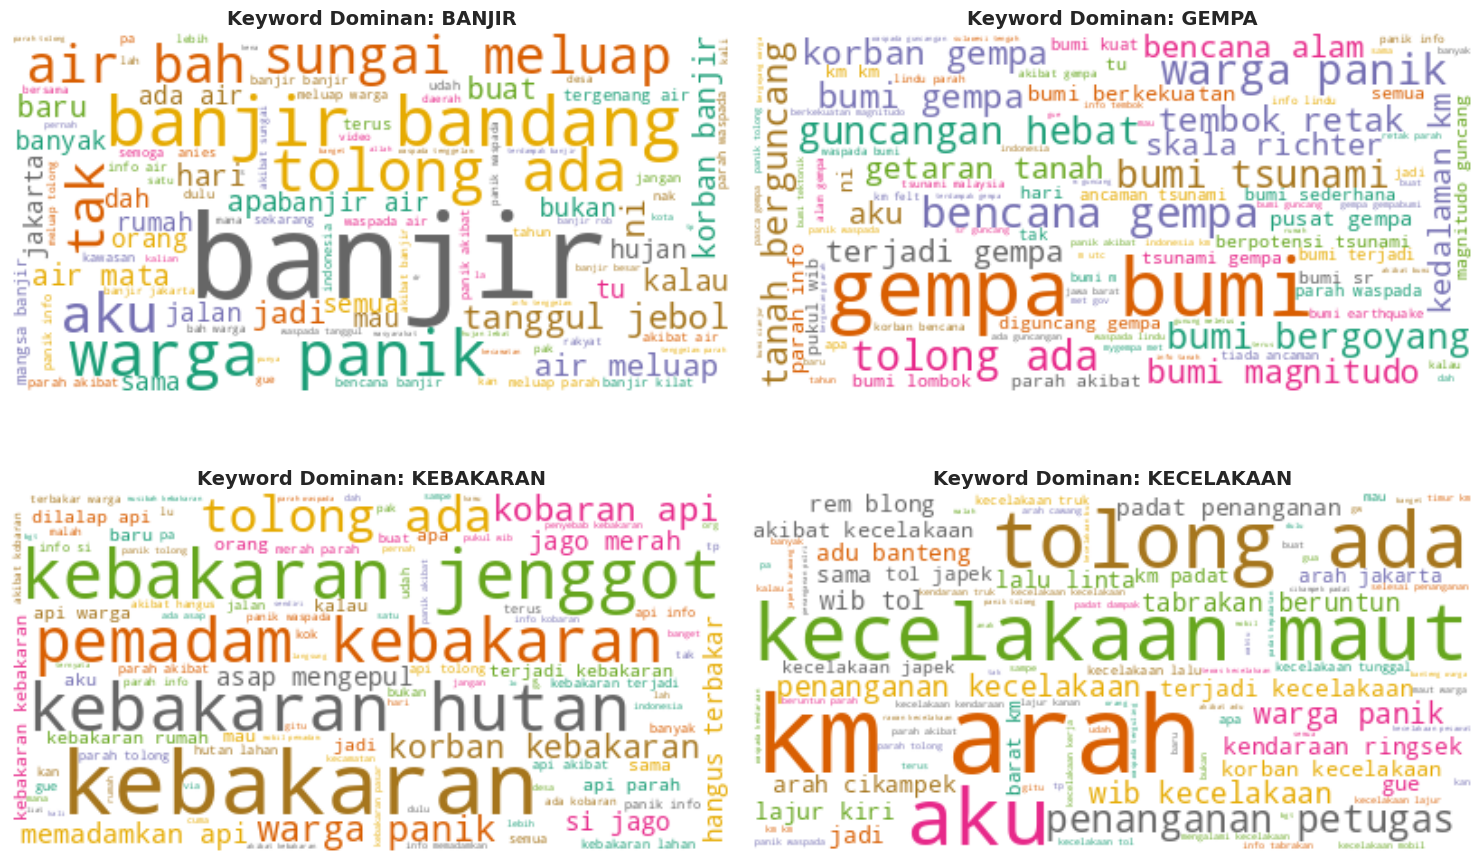

In [7]:
# Gabung text dan label untuk visualisasi
df_viz = pd.DataFrame({'text': X_train_final, 'label': y_train_final})
categories_map = {0: "BANJIR", 1: "GEMPA", 2: "KEBAKARAN", 3: "KECELAKAAN"}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for code, name in categories_map.items():
    text_data = " ".join(df_viz[df_viz['label'] == code]['text'].astype(str))
    wc = WordCloud(background_color='white', max_words=100, colormap='Dark2').generate(text_data)
    axes[code].imshow(wc, interpolation='bilinear')
    axes[code].set_title(f"Keyword Dominan: {name}", fontsize=14, fontweight='bold')
    axes[code].axis('off')

plt.tight_layout()
plt.show()

**Feature Engineering dan Training**

In [8]:
print("Mengubah Teks ke Angka (TF-IDF)")
tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1, 2))

X_train_vec = tfidf.fit_transform(X_train_final)

X_test_clean = [clean_text_v2(t) for t in X_test]
X_test_vec = tfidf.transform(X_test_clean)

Mengubah Teks ke Angka (TF-IDF)


In [9]:
start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf_model.fit(X_train_vec, y_train_final)

durasi = time.time() - start_time
print(f"Training Selesai dalam {durasi:.2f} detik.")

Training Selesai dalam 60.63 detik.


**Evaluasi**

MENGHITUNG METRIK EVALUASI

Overall Accuracy : 99.61%
Weighted F1-Score: 99.61% (Metrik Utama)
------------------------------------------------------------

DETAIL PERFORMA PER KATEGORI:


,precision,recall,f1-score,support
Banjir,0.995792,0.996491,0.996142,8550.000000
Gempa,0.994357,0.999190,0.996768,7407.000000
Kebakaran,0.999024,0.994620,0.996817,28811.000000
Kecelakaan,0.986132,0.998931,0.992490,6549.000000
macro avg,0.993826,0.997308,0.995554,51317.000000
weighted avg,0.996167,0.996142,0.996145,51317.000000


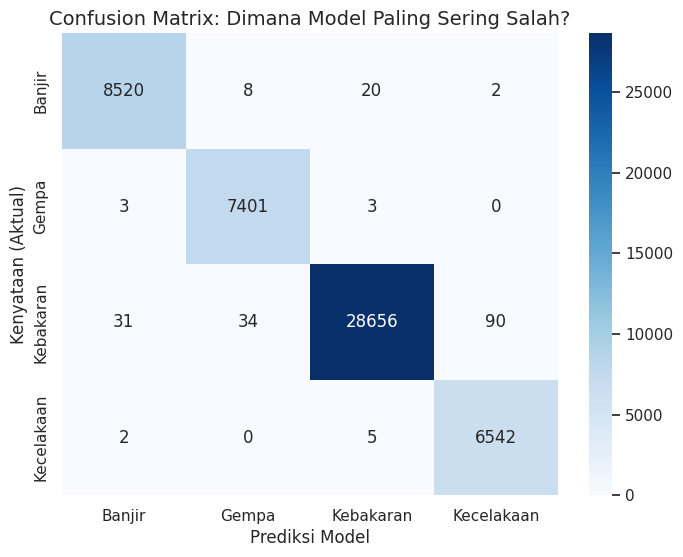

- Model memiliki F1-Score sebesar 99.61%, menunjukkan keseimbangan yang baik.
- RMSE tidak digunakan karena ini adalah masalah Klasifikasi Kategori, bukan Prediksi Angka (Regresi).


In [10]:
# EVALUASI METRIK
print("MENGHITUNG METRIK EVALUASI")

y_pred = rf_model.predict(X_test_vec)
target_names = ['Banjir', 'Gempa', 'Kebakaran', 'Kecelakaan']

acc = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(f"\nOverall Accuracy : {acc:.2%}")
print(f"Weighted F1-Score: {f1:.2%} (Metrik Utama)")
print("-" * 60)

report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

df_report = df_report.drop('accuracy', errors='ignore')

print("\nDETAIL PERFORMA PER KATEGORI:")
display(df_report.style.background_gradient(cmap='Greens', subset=['precision', 'recall', 'f1-score']))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix: Dimana Model Paling Sering Salah?', fontsize=14)
plt.ylabel('Kenyataan (Aktual)')
plt.xlabel('Prediksi Model')
plt.show()

print(f"- Model memiliki F1-Score sebesar {f1:.2%}, menunjukkan keseimbangan yang baik.")
print("- RMSE tidak digunakan karena ini adalah masalah Klasifikasi Kategori, bukan Prediksi Angka (Regresi).")

**Demo**

In [11]:
def predict_disaster_final(text):
    text_lower = text.lower()

    ignore_words = [
        "pray", "semoga", "turut", "berduka", "donasi", "open donasi",
        "hoax", "bohong", "galau", "sedih", "kangen", "rindu", "syahdu",
        "sejuk", "mendung", "gerimis", "pacar", "mantan"
    ]

    for w in ignore_words:
        if w in text_lower:
            return {
                "Status": "⛔ IGNORED",
                "Category": "-",
                "Confidence": f"0% (Noise: '{w}')"
            }

    keywords_pasti = {
        # Kebakaran
        "api": "Kebakaran", "terbakar": "Kebakaran", "kebakaran": "Kebakaran",
        "jago merah": "Kebakaran", "hangus": "Kebakaran", "asap": "Kebakaran",
        # Banjir
        "banjir": "Banjir", "terendam": "Banjir", "luapan": "Banjir",
        "mengungsi": "Banjir", "tanggul jebol": "Banjir", "genangan": "Banjir",
        # Gempa
        "gempa": "Gempa", "guncang": "Gempa", "lindu": "Gempa",
        "richter": "Gempa", "retak": "Gempa", "goyang": "Gempa",
        # Kecelakaan
        "kecelakaan": "Kecelakaan", "tabrakan": "Kecelakaan", "tewas": "Kecelakaan",
        "ringsek": "Kecelakaan", "ciuman": "Kecelakaan", "adu banteng": "Kecelakaan",
        "hantam": "Kecelakaan", "nabrak": "Kecelakaan", "seruduk": "Kecelakaan", "terguling": "Kecelakaan"
    }

    boosted_label = None
    trigger_word = None

    for word, label in keywords_pasti.items():
        if word in text_lower:
            boosted_label = label
            trigger_word = word
            break

    try:
        clean = clean_text_v2(text)
        vec = tfidf.transform([clean])
        probs = rf_model.predict_proba(vec)[0]
        max_prob = np.max(probs)
        pred_idx = np.argmax(probs)
        ml_label = label_mapping[pred_idx]
    except Exception as e:
        return {"Status": "ERROR", "Category": "-", "Confidence": str(e)}

    if boosted_label:
        final_conf = 0.99
        cat = boosted_label
        note = f"High Confidence (Keyword: '{trigger_word}')"
    else:
        final_conf = max_prob
        cat = ml_label
        note = "Model Prediction Only"

    status_icon = "ALERT" if final_conf > 0.45 else "UNCERTAIN"

    return {
        "Status": status_icon,
        "Category": cat,
        "Confidence": f"{final_conf:.1%} [{note}]"
    }

test_cases = [
    # KELOMPOK 1: SIMPATI & NOISE
    "Pray for Turkey semoga keluarga yang ditinggalkan tabah",
    "Open donasi untuk korban gempa cianjur, salurkan bantuanmu",
    "Turut berduka cita atas musibah yang menimpa saudara kita",
    "Berita itu cuma hoax jangan dipercaya guys",
    "Hujan rintik-rintik begini jadi kangen mantan yang dulu",
    "Langit mendung syahdu banget sore ini",

    # KELOMPOK 2: KEBAKARAN
    "Tolong ada api besar melahap ruko di pasar baru!",
    "Si jago merah mengamuk di kawasan padat penduduk",
    "Asap hitam tebal membumbung tinggi dari pabrik tekstil",
    "Warga panik melihat kobaran api makin membesar",

    # KELOMPOK 3: BANJIR
    "Air sungai ciliwung meluap sampai masuk teras rumah",
    "Banjir sepinggang orang dewasa di kemang, motor mogok",
    "Hujan deras dari pagi bikin jalanan tergenang parah",
    "Warga mulai mengungsi ke tempat yang lebih tinggi",

    # KELOMPOK 4: GEMPA
    "Barusan kerasa lindu kenceng banget woy",
    "Tanah berguncang beberapa detik, orang-orang lari keluar",
    "Info BMKG gempa 5.6 skala richter tidak berpotensi tsunami",
    "Lampu gantung di rumah goyang-goyang sendiri serem banget",

    # KELOMPOK 5: KECELAKAAN
    "Innalillahi ada tabrakan beruntun di tol cipularang",
    "Motor vs Truk adu banteng di jalur pantura, ngeri",
    "Pengendara motor ciuman sama aspal gara-gara lubang",
    "Truk rem blong hantam warung warga di pinggir jalan",
    "Mobil ringsek parah setelah nabrak pembatas jalan",

    # KELOMPOK 6: JEBAKAN
    "Banjir diskon di mall grand indonesia serbuuu!",
    "Hatiku terbakar api cemburu melihat dia sama orang lain"
]

print(f"{'KALIMAT INPUT':<60} | {'STATUS':<15} | {'KATEGORI':<12} | {'CONFIDENCE'}")
print("-" * 130)

for text in test_cases:
    res = predict_disaster_final(text)

    text_short = (text[:57] + '..') if len(text) > 57 else text
    conf_display = res['Confidence']

    print(f"{text_short:<60} | {res['Status']:<15} | {res['Category']:<12} | {conf_display}")

KALIMAT INPUT                                                | STATUS          | KATEGORI     | CONFIDENCE
----------------------------------------------------------------------------------------------------------------------------------
Pray for Turkey semoga keluarga yang ditinggalkan tabah      | ⛔ IGNORED       | -            | 0% (Noise: 'pray')
Open donasi untuk korban gempa cianjur, salurkan bantuanm..  | ⛔ IGNORED       | -            | 0% (Noise: 'donasi')
Turut berduka cita atas musibah yang menimpa saudara kita    | ⛔ IGNORED       | -            | 0% (Noise: 'turut')
Berita itu cuma hoax jangan dipercaya guys                   | ⛔ IGNORED       | -            | 0% (Noise: 'hoax')
Hujan rintik-rintik begini jadi kangen mantan yang dulu      | ⛔ IGNORED       | -            | 0% (Noise: 'kangen')
Langit mendung syahdu banget sore ini                        | ⛔ IGNORED       | -            | 0% (Noise: 'syahdu')
Tolong ada api besar melahap ruko di pasar baru!             | AL